This is basically an update on some parts of the overview tutorial from TF Probability.
I've changed some distributions, and experimented with other bijectors.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
tfd = tfp.distributions

In [2]:
sns.set()

tfd = tfp.distributions
tfb = tfp.bijectors

# Distributions

In [3]:
normal = tfd.Normal(loc=0., scale=1.)
print(normal)

tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)


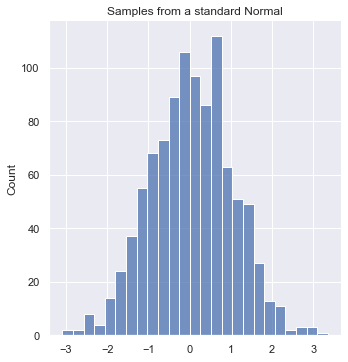

In [4]:
samples = normal.sample(1000)
sns.displot(samples)
plt.title("Samples from a standard Normal")
plt.show()

In [5]:
normal.log_prob(0.)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9189385>

In [6]:
ng_bin=tfd.NegativeBinomial(total_count=12,probs=0.5)
# Given a Bernoulli trial with probability p of success, 
# the NegativeBinomial distribution represents the distribution over the number of 
# successes s that occur until we observe f failures.

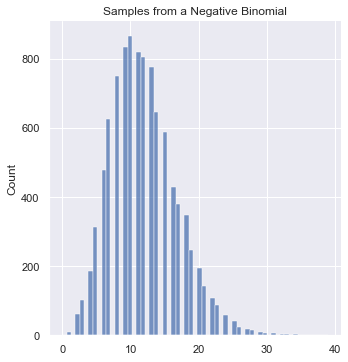

In [7]:
samples2 = ng_bin.sample(10000)
sns.displot(samples2)
plt.title("Samples from a Negative Binomial")
plt.show()

TensorFlow Probability Distributions have shape semantics -- we partition shapes into semantically distinct pieces, even though the same chunk of memory (Tensor/ndarray) is used for the whole everything.

+ Batch shape denotes a collection of Distributions with distinct parameters
+ Event shape denotes the shape of samples from the Distribution.

In [8]:
# Create a batch of 3 normals, and plot 1000 samples from each
normals = tfd.Normal([-2.5, 0., 2.5], 1.)  # The scale parameter broadacasts!
print("Batch shape:", normals.batch_shape)
print("Event shape:", normals.event_shape)

Batch shape: (3,)
Event shape: ()


In [9]:
samples = normals.sample(1000)
print("Shape of samples:", samples.shape)

Shape of samples: (1000, 3)


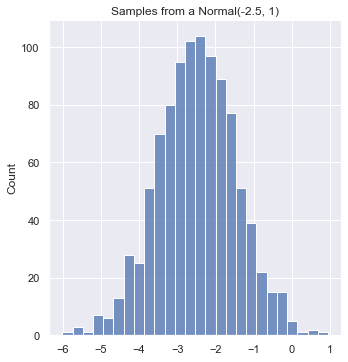

In [10]:
sns.displot(samples[:,0])
plt.title("Samples from a Normal(-2.5, 1)")
plt.show()

In [11]:
# A batch of normals gives a batch of log_probs.
print(normals.log_prob([-2.5, 0., 2.5]))

tf.Tensor([-0.9189385 -0.9189385 -0.9189385], shape=(3,), dtype=float32)


In [12]:
print(normals.log_prob(0.))

tf.Tensor([-4.0439386 -0.9189385 -4.0439386], shape=(3,), dtype=float32)


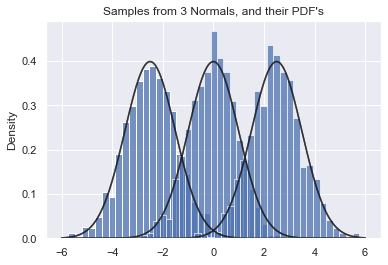

In [13]:
xs = np.linspace(-6, 6, 200)[:,np.newaxis]
for i in range(3):
    sns.histplot(samples[:, i], kde=False, stat="density")
    plt.plot(np.tile(xs, 3), normals.prob(xs), c='k', alpha=.5)
    plt.title("Samples from 3 Normals, and their PDF's")
plt.show()

## Vector Distribution

In [14]:
covariance_matrix = [[1., 1],[1,2.]]
mvn = tfd.MultivariateNormalTriL(loc=[0., 0.],scale_tril=tf.linalg.cholesky(covariance_matrix))
print("Batch shape:", mvn.batch_shape)
print("Event shape:", mvn.event_shape)

Batch shape: ()
Event shape: (2,)


In [15]:
samples = mvn.sample(1000)
print("Samples shape:", samples.shape)

Samples shape: (1000, 2)


In [16]:
samples[0,1]

<tf.Tensor: shape=(), dtype=float32, numpy=1.1693045>

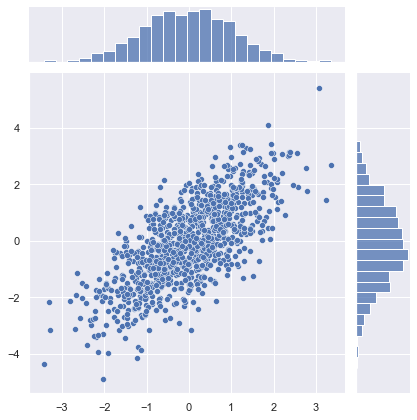

In [17]:
sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind='scatter')
plt.show()

In [18]:
mu = [1., 2]
cov = [[ 1,  0.5],
       [ 0.5, 1]]
mvn = tfd.MultivariateNormalFullCovariance(
    loc=mu,
    covariance_matrix=cov)

samples = mvn.sample(1000)
print("Samples shape:", samples.shape)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Samples shape: (1000, 2)


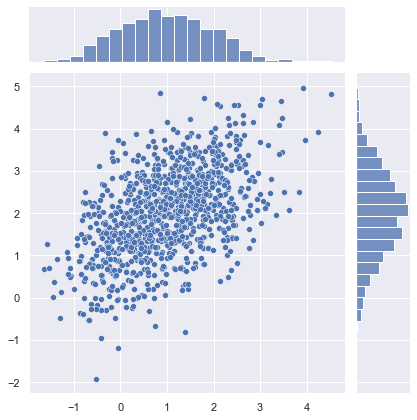

In [19]:
sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind='scatter')
plt.show()

## Matrix Distributions

In [20]:
lkj = tfd.LKJ(dimension=10, concentration=[1.5, 3.0])
print("Batch shape: ", lkj.batch_shape)
print("Event shape: ", lkj.event_shape)

Batch shape:  (2,)
Event shape:  (10, 10)


Event Shape = Dimension of each Distribution

Batch Shape = Number of Distributions

In [21]:
samples = lkj.sample()
print("Samples shape: ", samples.shape)

Samples shape:  (2, 10, 10)


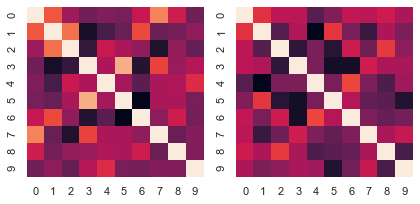

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
sns.heatmap(samples[0,:], ax=axes[0], cbar=False)
sns.heatmap(samples[1,:], ax=axes[1], cbar=False)
fig.tight_layout()
plt.show()

# Gaussian Distributions

## Prior

In [23]:
kernel = tfp.math.psd_kernels.ExponentiatedQuadratic()
xs = np.linspace(-5., 5., 200).reshape([-1, 1])
gp = tfd.GaussianProcess(kernel, index_points=xs)
print("Batch shape:", gp.batch_shape)
print("Event shape:", gp.event_shape)

Batch shape: ()
Event shape: (200,)


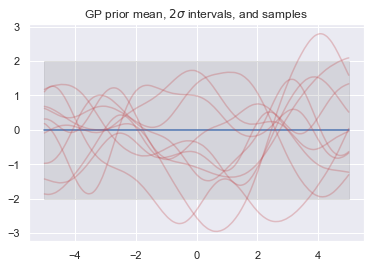

In [24]:
upper, lower = gp.mean() + [2 * gp.stddev(), -2 * gp.stddev()]
plt.plot(xs, gp.mean())
plt.fill_between(xs[:, 0], upper, lower, color='k', alpha=.1)
for _ in range(10):
    plt.plot(xs, gp.sample(), c='r', alpha=.3)
plt.title(r"GP prior mean, $2\sigma$ intervals, and samples")
plt.show()

## GP Regression

In [25]:
# Suppose we have some observed data
obs_x = [[-3.], [0.], [2.]]  # Shape 3x1 (3 1-D vectors)
obs_y = [3., -2., 2.]        # Shape 3   (3 scalars)

# Here's the regression model
gprm = tfd.GaussianProcessRegressionModel(kernel, xs, obs_x, obs_y)

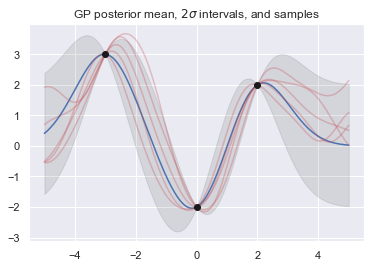

In [26]:
upper, lower = gprm.mean() + [2 * gprm.stddev(), -2 * gprm.stddev()]
plt.plot(xs, gprm.mean())
plt.fill_between(xs[:, 0], upper, lower, color='k', alpha=.1)
for _ in range(5):
    plt.plot(xs, gprm.sample(), c='r', alpha=.3)
plt.scatter(obs_x, obs_y, c='k', zorder=3)
plt.title(r"GP posterior mean, $2\sigma$ intervals, and samples")
plt.show()

# Bijectors (invertible, smooth functions)

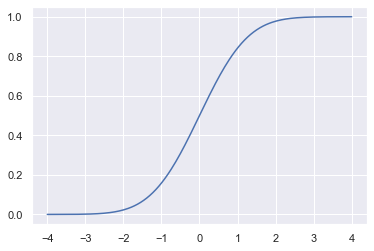

In [27]:
normal_cdf = tfp.bijectors.NormalCDF()
xs = np.linspace(-4., 4., 200)
plt.plot(xs, normal_cdf.forward(xs))
plt.show()

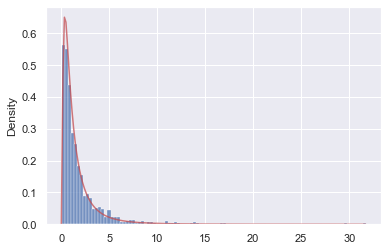

In [35]:
exp_bijector = tfp.bijectors.Exp()
log_normal = exp_bijector(tfd.Normal(0., 1))

samples = log_normal.sample(1000)
xs = np.linspace(1e-10, np.max(samples), 200)
sns.histplot(samples, stat="density", kde=False)
#plt.plot(xs, log_normal.prob(xs), c='k', alpha=.75)
log_normal_direct=tfp.distributions.LogNormal(
    loc=0, scale=1)# Exp(N(0,1)) = Log-Normal(0,1)
plt.plot(xs, log_normal_direct.prob(xs), c='r', alpha=.75)
# Works well
plt.show()

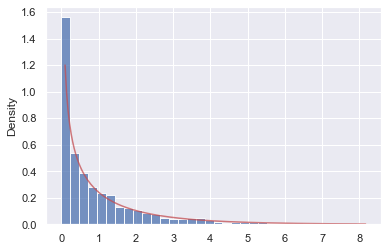

In [44]:
square_bijector=tfp.bijectors.Square()
chi_squared=square_bijector(tfd.Normal(0., 1))

samples = chi_squared.sample(1000)
xs = np.linspace(0.1, np.max(samples), 200) 
# I changed the mininmum, otherwise, the graph would be a bit ugly... 
sns.histplot(samples, stat="density", kde=False)
 
chi_squared_direct=tfp.distributions.Chi2(
     df=1)# (N(0,1))^2 = Chi-Squared(1)
plt.plot(xs, chi_squared_direct.prob(xs), c='r', alpha=.75)
# Works well
plt.show()

The first bin seems to go over the density of the chi-squared, but that's only because I cut the x axis for the density at 0.1. Change the x_min to 0.01 above, and it will go very easily over it.

## Batching Bijectors

In [45]:
softplus = tfp.bijectors.Softplus(
  hinge_softness=[1., .5, .1])
print("Hinge softness shape:", softplus.hinge_softness.shape)

Hinge softness shape: (3,)


This bijector $g$ with hinge_softness equal to $c$ is such that $$Y = g(X) = c\log\left(1 + \exp\left(\frac{X}{c}\right)\right)$$

In [46]:
xs = np.linspace(-4., 4., 200)[:, np.newaxis]
ys = softplus.forward(xs)
print("Forward shape:", ys.shape)

Forward shape: (200, 3)


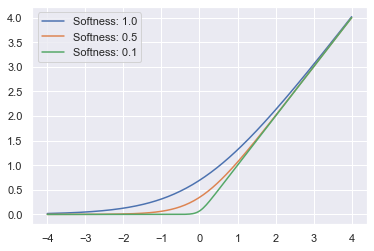

In [51]:
lines = plt.plot(np.tile(xs, reps=3), ys)
# numpy.tile - Construct an array by repeating A the number of times given by reps.

for line, hs in zip(lines, softplus.hinge_softness):
    line.set_label("Softness: %1.1f" % hs)
plt.legend()
plt.show()

In [53]:
bij = tfb.CholeskyOuterProduct()

size = 2500
# Make a big, lower-triangular matrix
big_lower_triangular = tf.eye(size)
# Squaring it gives us a positive-definite matrix
big_positive_definite = bij.forward(big_lower_triangular)

# Caching for the win!
%timeit bij.inverse(big_positive_definite)
%timeit tf.linalg.cholesky(big_positive_definite)

412 µs ± 9.18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
708 ms ± 3.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Yes, my pc is that slow (and old).